id: (Categorical) A unique identifier for each observation

vendor_id: (Categorical) A code indicating the provider associated with the trip record

pickup_datetime: (Numerical Datetime) Date and time when the meter was engaged

dropoff_datetime: (Numerical Datetime) Date and time when the meter was disengaged

passenger_count: (Numerical) The number of passengers in the vehicle (driver entered value)

pickup_longitude: (Numerical) The longitude where the meter was engaged

pickup_latitude: (Numerical) The latitude where the meter was engaged

dropoff_longitude: (Numerical) The longitude where the meter was disengaged

dropoff_latitude: (Numerical) The latitude where the meter was disengaged

store_and_fwd_flag: (Categorical) This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)

trip_duration: (Numerical) Duration of the trip in seconds

In [1]:
!pip install folium

In [2]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Карта Москвы.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso

%matplotlib inline

sns.set(style="darkgrid")

In [4]:
df = pd.read_csv("D:/ML/ВШЭ_курс/Data/taxi/train.csv")
data_t = pd.read_csv("D:/ML/ВШЭ_курс/Data/taxi/test.csv")

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [5]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
data_t.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [7]:
set_train = set(df.columns.tolist())
set_test = set(data_t.columns.tolist())
set_train.symmetric_difference(set_test)

{'dropoff_datetime', 'trip_duration'}

In [8]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [9]:
dropoff_datetime = df['dropoff_datetime']
df = df.drop("dropoff_datetime", axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   passenger_count     1458644 non-null  int64         
 4   pickup_longitude    1458644 non-null  float64       
 5   pickup_latitude     1458644 non-null  float64       
 6   dropoff_longitude   1458644 non-null  float64       
 7   dropoff_latitude    1458644 non-null  float64       
 8   store_and_fwd_flag  1458644 non-null  object        
 9   trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 111.3+ MB


In [11]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$



The evaluation metric for this competition is Root Mean Squared Logarithmic Error. This is done so as not to add a great deal of error on long trips

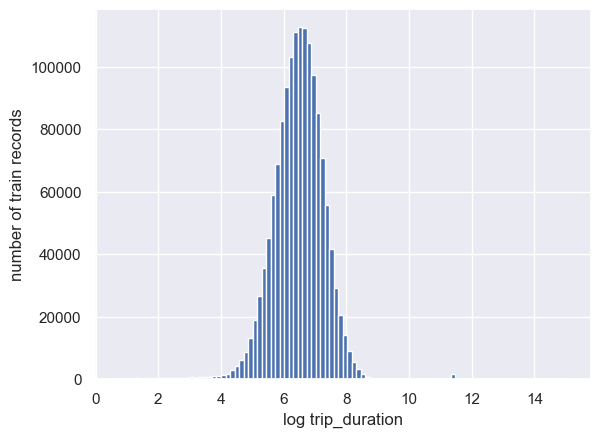

In [12]:
df['log_trip_duration'] = np.log1p(df['trip_duration'])
plt.hist(df['log_trip_duration'], bins=100)
plt.xlabel('log trip_duration')
plt.ylabel('number of train records')
plt.show()

In [13]:
trip_duration = df['trip_duration']
df = df.drop(['trip_duration'], axis=1)

In [14]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,log_trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,6.466978e+00
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,7.957595e-01
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,6.931472e-01
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,5.986452e+00
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.496775e+00
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,6.981006e+00
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,1.507575e+01


Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [15]:
y_const = pd.Series(df['log_trip_duration'].mean(), index=range(df.shape[0]))
metrics.mean_absolute_error(df['log_trip_duration'], y_const)

0.6054636388308124

## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

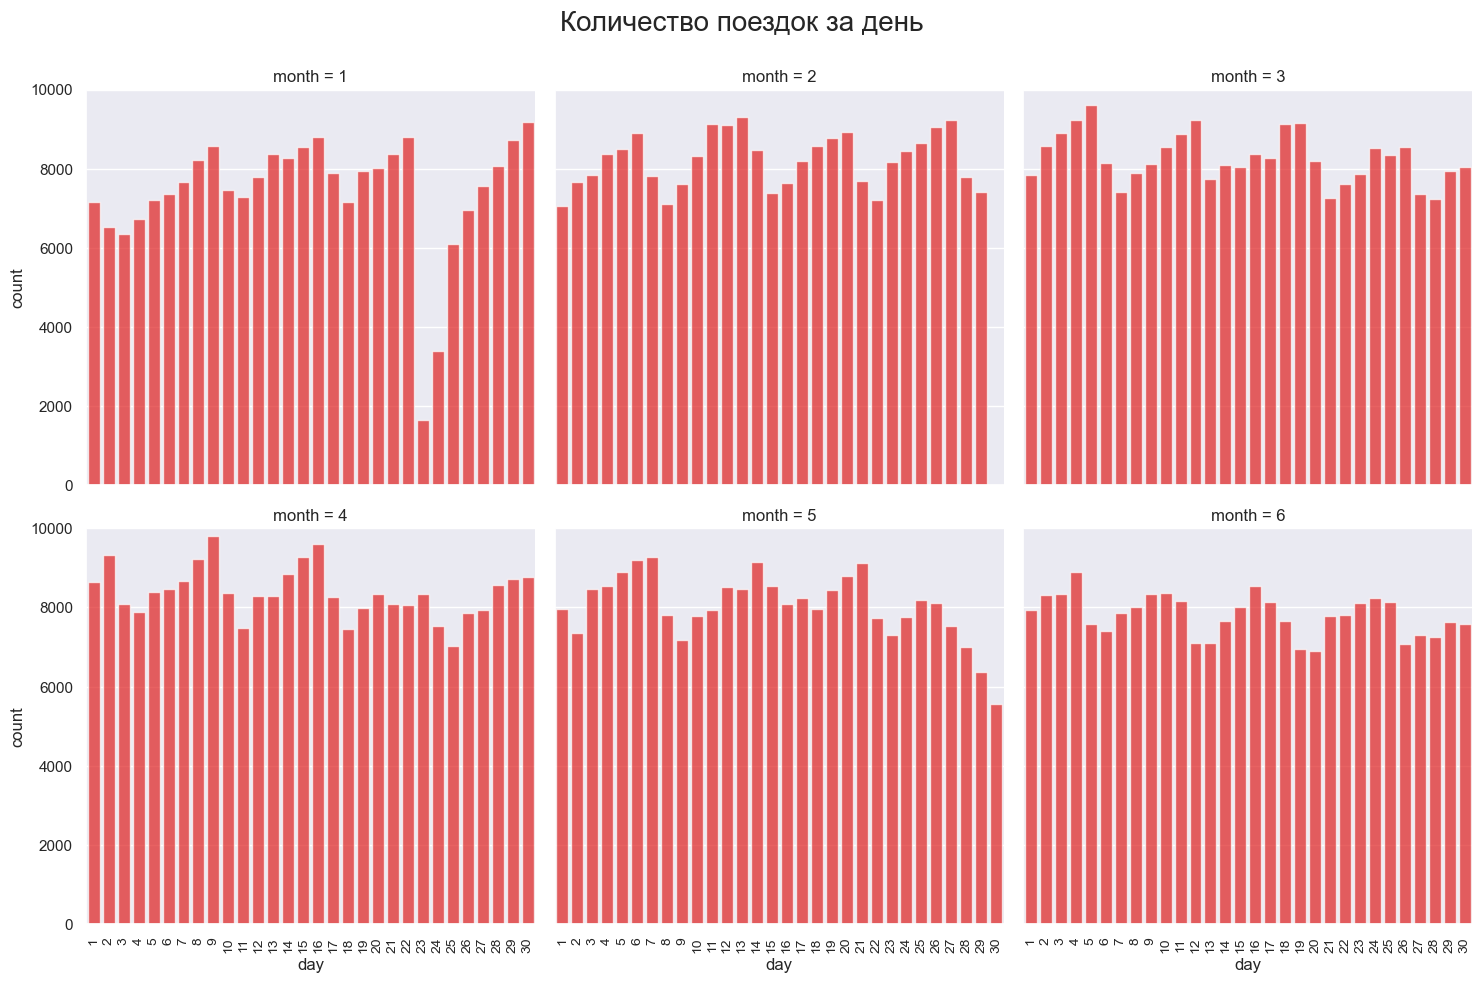

In [16]:
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day

g = sns.FacetGrid(df, col='month', col_wrap=3, height=5, ylim=(0,10000))
g.map(sns.countplot, 'day', color='red', alpha=0.7,
      order=[i for i in range(1,31)])
g.set_xticklabels(fontsize=10, rotation=90)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Количество поездок за день', fontsize=20)

df.drop(columns=['month','day'], inplace=True)

На графике есть 2 периода с аномально маленькими количествами поездок. Посмотрим, в какие даты происходили эти скачки вниз

In [17]:
df['pickup_datetime'][4]

Timestamp('2016-03-26 13:30:55')

I find out that: The January 2016 United States blizzard was a blizzard that produced up to 3 ft (91 cm) of snow in parts of the Mid-Atlantic and Northeastern United States from January 22–24, 2016. So vehicles were banned

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

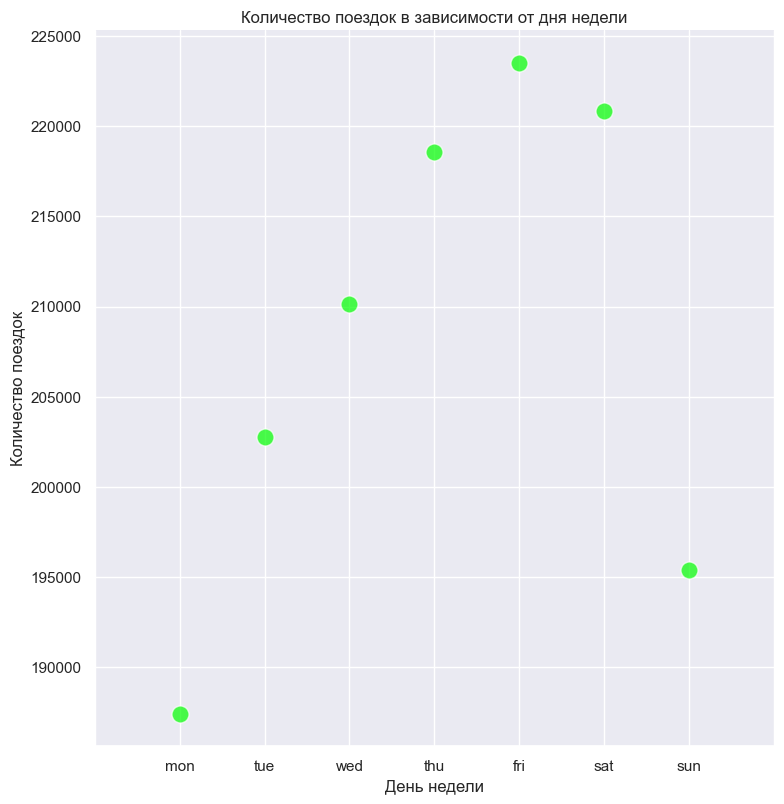

In [18]:
df['day_of_week'] = df['pickup_datetime'].dt.day_of_week

ax = sns.relplot(x=df['day_of_week'].value_counts().index,
                 y=df['day_of_week'].value_counts().values,
                 s=150, color='lime', alpha=0.7, height=8)
ax.set(title='Количество поездок в зависимости от дня недели',
       xlabel='День недели',
       ylabel='Количество поездок')
ax.set_xticklabels(['','mon','tue','wed','thu','fri','sat','sun',''])

df.drop(columns='day_of_week', inplace=True)

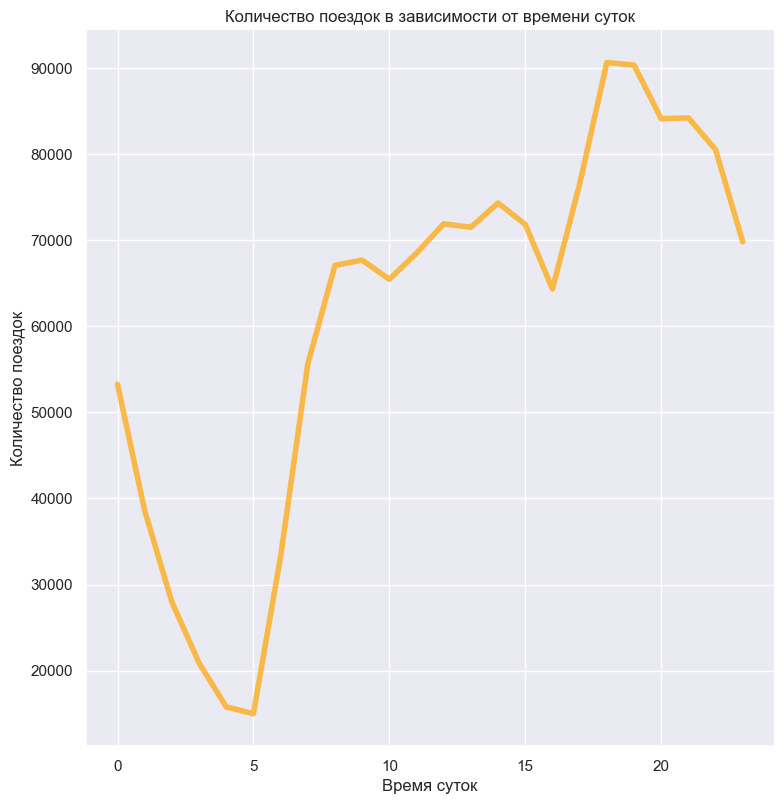

In [19]:
df['hour'] = df['pickup_datetime'].dt.hour
ax = sns.relplot(x=df['hour'].value_counts().index,
                 y=df['hour'].value_counts().values,
                 color='orange', alpha=0.7, kind='line',
                 height=8, linewidth=4) 
ax.set(title='Количество поездок в зависимости от времени суток',
       xlabel='Время суток',
       ylabel='Количество поездок')

df.drop(columns='hour', inplace=True)

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [20]:
df['hour'] = df['pickup_datetime'].dt.hour
df['month'] = df['pickup_datetime'].dt.month

gb_month_hour = pd.DataFrame(df.groupby(by=['month','hour'])['id'].count())
gb_month_hour.reset_index(level=['month','hour'], inplace=True)

df.drop(columns=['hour','month'], inplace=True)

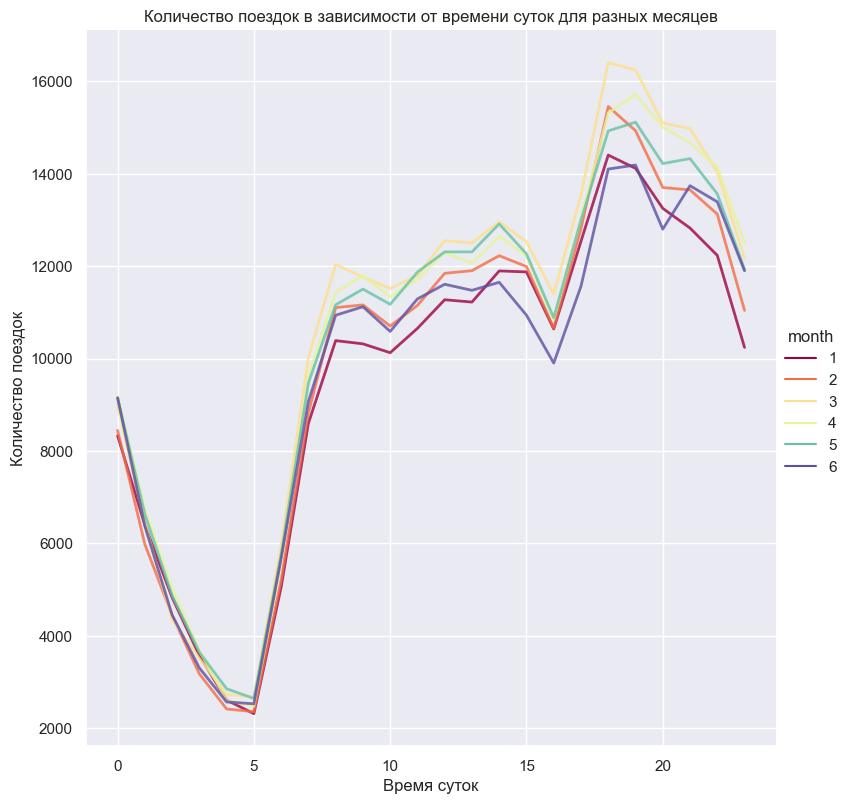

In [21]:
ax = sns.relplot(data=gb_month_hour, x='hour', y='id',
                 alpha=0.8, kind='line', palette='Spectral',
                 height=8, linewidth=2, hue='month')
ax.set(title='Количество поездок в зависимости от времени суток для разных месяцев',
       xlabel='Время суток',
       ylabel='Количество поездок')

In [22]:
df['day_of_week'] = df['pickup_datetime'].dt.day_of_week
df['hour'] = df['pickup_datetime'].dt.hour

gb_dow_hour = pd.DataFrame(df.groupby(by=['day_of_week','hour'])['id'].count())
gb_dow_hour.reset_index(level=['day_of_week','hour'], inplace=True)

df.drop(columns=['day_of_week','hour'], inplace=True)

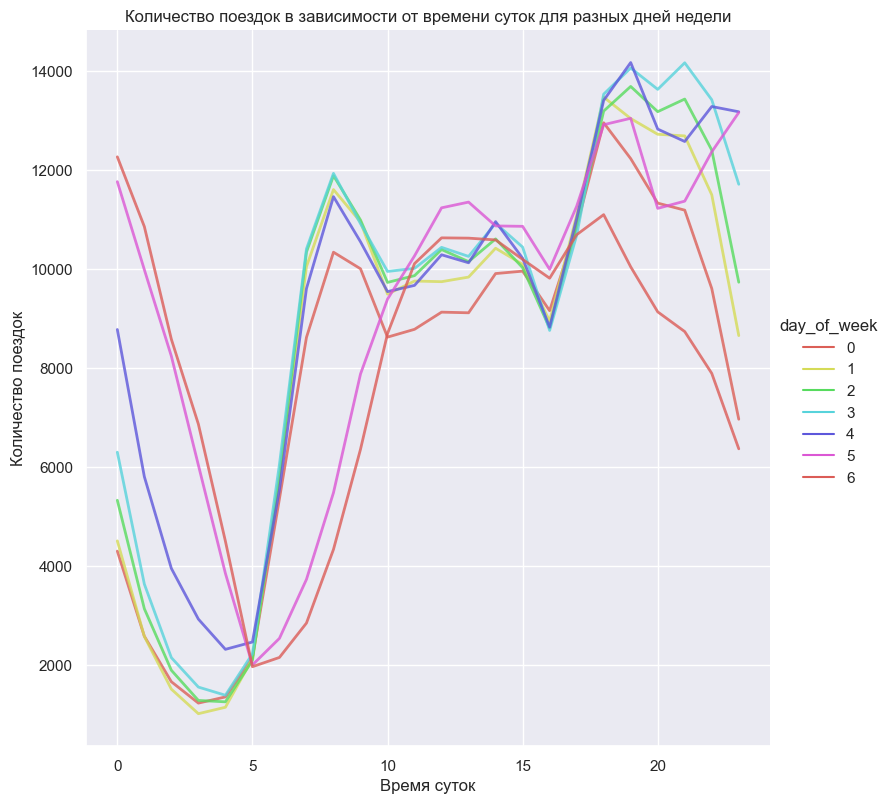

In [23]:
ax = sns.relplot(data=gb_dow_hour, x='hour', y='id',
                 alpha=0.8, kind='line', palette='hls',
                 height=8, linewidth=2, hue='day_of_week')
ax.set(title='Количество поездок в зависимости от времени суток для разных дней недели',
       xlabel='Время суток',
       ylabel='Количество поездок')

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

Ответ: В разные месяцы зависимость количества поездок от времени суток значительно не менялась.

В субботу и воскресенье зависимость количества поездок от времени суток отличается от зависимости в будние дни:

1. В период с 00 до 05 часов в выходные дни поездок больше, чем в будние дни (вероятнее всего, многие в это время возвращаются из баров, ресторанов, от друзей и т.д.)
2. В период с 20 до 23 в пятницу и субботу также заметно увеличение количества поездок (можно объяснить теми же самыми причинами)
3. В будние дни есть два периода с высокой активностью: 7 - 9 и 18 - 21, которых нет в выходные (люди едут на работу и возвращаюся с нее в это время)

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

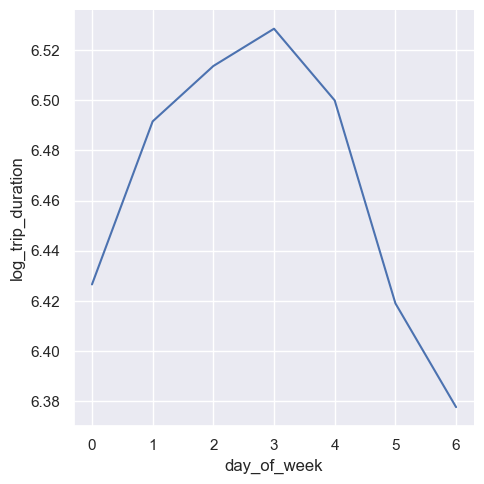

In [24]:
df['day_of_week'] = df['pickup_datetime'].dt.day_of_week
data_gr = df.groupby("day_of_week").mean()
sns.relplot(data=data_gr, x="day_of_week", y="log_trip_duration", kind="line")

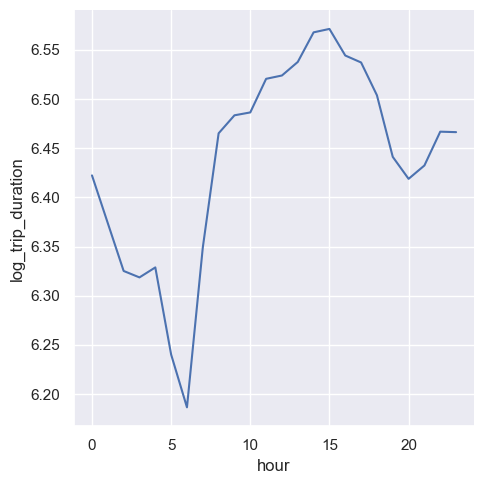

In [25]:
df['hour'] = df['pickup_datetime'].dt.hour
data_gr3 = df.groupby("hour").mean()
sns.relplot(data=data_gr3, x="hour", y="log_trip_duration", kind="line")

df.drop(columns='hour', inplace=True)

<AxesSubplot:xlabel='day', ylabel='log_trip_duration'>

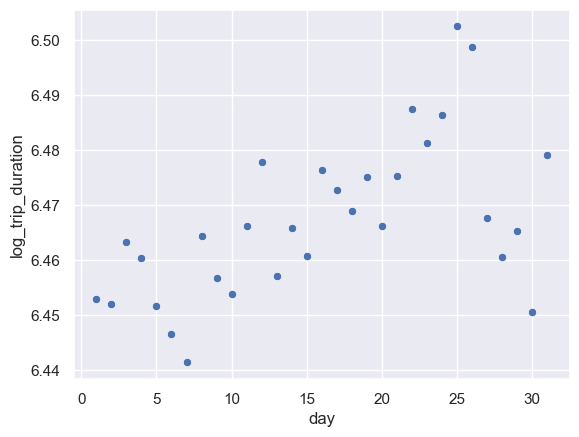

In [26]:
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day

data_gr = df.groupby("day").mean()
sns.scatterplot(data=data_gr, x="day", y="log_trip_duration")

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [27]:
def new_columns(df):
    return df.assign(
        day_of_week=df['pickup_datetime'].dt.day_of_week,
        month=df['pickup_datetime'].dt.month,
        hour=df['pickup_datetime'].dt.hour,
        is_anomaly_1=((df['pickup_datetime'].dt.day == 23) & (df['pickup_datetime'].dt.month == 1)) |\
                     ((df['pickup_datetime'].dt.day == 24) & (df['pickup_datetime'].dt.month == 1)) |\
                     ((df['pickup_datetime'].dt.day == 25) & (df['pickup_datetime'].dt.month == 1)),
        is_anomaly_2=((df['pickup_datetime'].dt.day == 30) & (df['pickup_datetime'].dt.month == 5)),
        day_of_year=df['pickup_datetime'].dt.day_of_year)

In [28]:
df_test = pd.read_csv("D:/ML/ВШЭ_курс/Data/taxi/test.csv", parse_dates=['pickup_datetime'])

In [29]:
df_test.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')

In [30]:
df = new_columns(df)
df_test = new_columns(df_test)

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [31]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [32]:
df_r = df.copy()
df_testr = df_test.copy()

In [33]:
df_r = df_r.drop(columns=['id','vendor_id','pickup_datetime'], axis=1)

In [34]:
categorical = ['store_and_fwd_flag','day_of_week','month','hour']

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe_res = ohe.fit_transform(df_r[categorical])
new_columns = ohe.get_feature_names_out(categorical)

df_r = df_r.join(pd.DataFrame(ohe_res, columns=new_columns)).drop(columns=categorical)

D:\MachineLearning\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [35]:
X_train = df_r.drop(columns='log_trip_duration')
y_train = df_r['log_trip_duration']

In [36]:
model = Ridge()
cv_baseline = cross_val_score(
    model,
    X_train,
    y_train,
    cv=5, 
    scoring='neg_root_mean_squared_error').mean()

print(-cv_baseline)

0.7737118417857156


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [37]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [38]:
loc = show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")
loc.location

[40.751612926483155, -73.97306624603272]

In [39]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

The most popular places are aeroport and peninsula

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [40]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [41]:
import haversine
from haversine import haversine

In [42]:
df['distance_haversine'] = df.apply(lambda x: haversine((x.pickup_latitude, x.pickup_longitude),
                                               (x.dropoff_latitude,x.dropoff_longitude)),
                                       axis=1)

In [43]:
df_test['distance_haversine'] = df_test.apply(lambda x: haversine((x.pickup_latitude, x.pickup_longitude),
                                               (x.dropoff_latitude,x.dropoff_longitude)),
                                     axis=1)

In [44]:
#df['distance_haversine'] = haversine_array(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])

In [45]:
#df_test['distance_haversine'] = haversine_array(df_test['pickup_latitude'], df_test['pickup_longitude'], df_test['dropoff_latitude'], df_test['dropoff_longitude'])

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [46]:
df['log_dist_haversine'] = np.log1p(df["distance_haversine"])

In [47]:
df_test['log_dist_haversine'] = np.log1p(df_test['distance_haversine'])

In [48]:
df['log_dist_haversine'].min()

0.0

In [49]:
#df.drop(columns=['haversine'], inplace=True)

In [50]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,log_trip_duration,day_of_week,month,day,hour,day_of_year,distance_haversine,log_dist_haversine
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,6.466978e+00,3.050375e+00,3.516818e+00,1.550402e+01,1.360648e+01,9.183607e+01,3.440869e+00,1.254587e+00
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,7.957595e-01,1.954039e+00,1.681038e+00,8.703135e+00,6.399693e+00,5.156608e+01,4.296544e+00,6.271531e-01
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,6.931472e-01,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,5.986452e+00,1.000000e+00,2.000000e+00,8.000000e+00,9.000000e+00,4.800000e+01,1.231838e+00,8.028256e-01
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.496775e+00,3.000000e+00,4.000000e+00,1.500000e+01,1.400000e+01,9.200000e+01,2.093720e+00,1.129374e+00
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,6.981006e+00,5.000000e+00,5.000000e+00,2.300000e+01,1.900000e+01,1.360000e+02,3.875343e+00,1.584190e+00
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,1.507575e+01,6.000000e+00,6.000000e+00,3.100000e+01,2.300000e+01,1.820000e+02,1.240910e+03,7.124406e+00


Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [51]:
corrmat = df[['log_dist_haversine', 'distance_haversine', 'log_trip_duration']].corr()
corrmat

,log_dist_haversine,distance_haversine,log_trip_duration
log_dist_haversine,1.000000,0.844501,0.749882
distance_haversine,0.844501,1.000000,0.573595
log_trip_duration,0.749882,0.573595,1.000000


**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

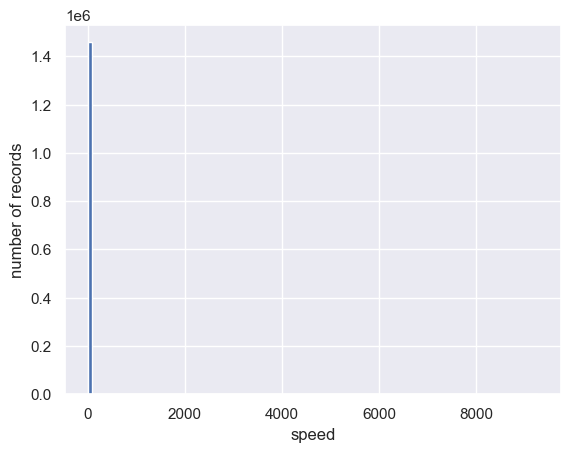

In [52]:
df['speed'] = df['distance_haversine'] / (trip_duration / 3600)

plt.hist(df['speed'], bins=100)
plt.xlabel('speed')
plt.ylabel('number of records')
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [53]:
np.percentile(df['speed'], 90)
print(df['speed'].min(), df['speed'].max()) 

0.0 9274.849542192556


(array([10831.,  1786.,  1361.,  1505.,  1821.,  2473.,  3534.,  4776.,
         6443.,  8408., 10884., 13370., 16416., 18952., 21756., 24763.,
        27638., 30034., 32989., 34670., 36652., 38276., 39800., 40513.,
        41040., 41271., 41762., 41020., 40982., 39737., 38731., 37801.,
        36087., 35201., 34147., 32252., 30785., 29568., 27798., 26655.,
        25448., 24000., 22918., 21286., 20227., 19048., 17977., 16933.,
        16061., 15212., 14426., 13539., 12752., 11890., 11367., 10518.,
         9970.,  9447.,  8803.,  8367.,  7878.,  7360.,  7036.,  6614.,
         6248.,  5838.,  5697.,  5366.,  4868.,  4581.,  4299.,  4240.,
         3932.,  3831.,  3525.,  3278.,  3118.,  3007.,  2854.,  2697.,
         2634.,  2400.,  2324.,  2206.,  2048.,  1986.,  1880.,  1752.,
         1701.,  1655.,  1521.,  1523.,  1425.,  1312.,  1266.,  1235.,
         1148.,  1141.,   990.,   966.]),
 array([ 0.        ,  0.4074536 ,  0.8149072 ,  1.2223608 ,  1.62981441,
         2.03726801, 

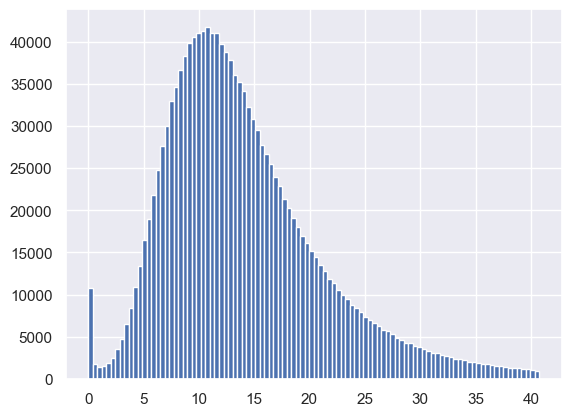

In [54]:
plt.hist(df['speed'], bins=100, range=(0, np.percentile(df['speed'], 99)))

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

<AxesSubplot:xlabel='hour', ylabel='day_of_week'>

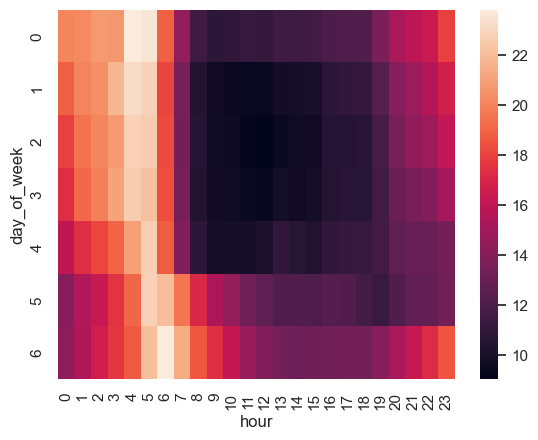

In [55]:
speed_median = df.groupby(['day_of_week', 'hour'])['speed'].median()
speed_median = speed_median.reset_index()
speed_heat = speed_median.pivot('day_of_week', 'hour', 'speed')
sns.heatmap(speed_heat)

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

In [56]:
df = df.drop("speed", axis=1)

Скорость нельзя оставлять, потому что она линейно зависит от других переменных

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [57]:
df['in_traffic'] = df['day_of_week'].between(1, 4, inclusive="both") & df['hour'].between(9, 12, inclusive="both")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 20 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   passenger_count     1458644 non-null  int64         
 4   pickup_longitude    1458644 non-null  float64       
 5   pickup_latitude     1458644 non-null  float64       
 6   dropoff_longitude   1458644 non-null  float64       
 7   dropoff_latitude    1458644 non-null  float64       
 8   store_and_fwd_flag  1458644 non-null  object        
 9   log_trip_duration   1458644 non-null  float64       
 10  day_of_week         1458644 non-null  int64         
 11  month               1458644 non-null  int64         
 12  day                 1458644 non-null  int64         
 13  hour        

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.  ИМЕЕТСЯ В ВИДУ ВЫБРОСЫ???

In [58]:
samle = df[df['dropoff_latitude'] == df['dropoff_latitude'].max()]
show_circles_on_map(samle, "dropoff_latitude", "dropoff_longitude", "blue")
# haversine_array(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
# df['from_aeroport'] = haversine_array(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

<AxesSubplot:xlabel='in_traffic', ylabel='log_trip_duration'>

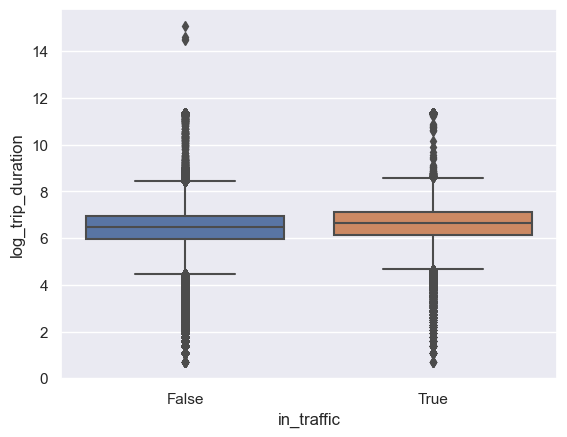

In [59]:
sns.boxplot(data=df, x="in_traffic", y='log_trip_duration')

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

Не очень, потому что много выбросов.

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [60]:
from folium.plugins import MousePosition

In [61]:
cordin = loc.location
cordin

[40.751612926483155, -73.97306624603272]

In [62]:
m = folium.Map(location=cordin, zoom_start=10)

Добавим возможность просмотра координат, чтобы определить границы прямоугольника.
Левая верхняя вершина: (-74.024; 40.797)
Правая нижняя вершина: (-73.934; 40.707)

In [63]:
formatter = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"

MousePosition(
    position="topright",
    separator=" | ",
    empty_string="NaN",
    lng_first=True,
    num_digits=20,
    prefix="Coordinates:",
    lat_formatter=formatter,
    lng_formatter=formatter,
).add_to(m)

m

In [64]:
from sklearn.base import BaseEstimator, TransformerMixin


# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently

class MapGridTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, hor_bins, ver_bins):
        self.hor_bins = hor_bins
        self.ver_bins = ver_bins
        
        self.pickup_long = []
        self.pickup_lat = []
        self.dropoff_long = []
        self.dropoff_lat = []

    def fit(self, df):
        x0 = df['pickup_longitude'].quantile(0.01)
        xn = df['pickup_longitude'].quantile(0.99)
        self.pickup_long.append(x0)
        for i in range(1, self.hor_bins):
            xi = ((xn - x0) / self.hor_bins) * i + x0
            self.pickup_long.append(xi)
        self.pickup_long.append(xn)

        x0 = df['pickup_latitude'].quantile(0.01)
        xn = df['pickup_latitude'].quantile(0.99)
        self.pickup_lat.append(x0)
        for i in range(1, self.ver_bins):
            xi = ((xn - x0) / self.ver_bins) * i + x0
            self.pickup_lat.append(xi)
        self.pickup_lat.append(xn)

        x0 = df['dropoff_longitude'].quantile(0.01)
        xn = df['dropoff_longitude'].quantile(0.99)
        self.dropoff_long.append(x0)
        for i in range(1, self.hor_bins):
            xi = ((xn - x0) / self.hor_bins) * i + x0
            self.dropoff_long.append(xi)
        self.dropoff_long.append(xn)

        x0 = df['dropoff_latitude'].quantile(0.01)
        xn = df['dropoff_latitude'].quantile(0.99)
        self.dropoff_lat.append(x0)
        for i in range(1, self.ver_bins):
            xi = ((xn - x0) / self.ver_bins) * i + x0
            self.dropoff_lat.append(xi)
        self.dropoff_lat.append(xn)

        return self

    def __subtransform(self, lng, lat, long_bounds, lat_bounds):
        if (lng < long_bounds[0] or lat < lat_bounds[0] or
           lng > long_bounds[-1] or lat > lat_bounds[-1]):
            square = -1
        else:
            square = 0
            for n, c in enumerate(long_bounds):
                if c > lng:
                    square += n - 1
                    break
            for n, c in enumerate(lat_bounds):
                if c > lat:
                    square += (n - 1) * (len(long_bounds) - 1)
                    break

        return square

    def transform(self, df):
        return df.assign(
            pickup_square=df.apply(
                lambda x: self.__subtransform(
                    x.pickup_longitude, x.pickup_latitude,
                    self.pickup_long, self.pickup_lat),
                axis=1),
            dropoff_square=df.apply(
                lambda x: self.__subtransform(
                    x.dropoff_longitude, x.dropoff_latitude,
                    self.dropoff_long, self.dropoff_lat),
                axis=1))
    

In [65]:
%%time
mgt = MapGridTransformer(5,5)
df = mgt.fit_transform(df)

CPU times: total: 57.6 s
Wall time: 58.8 s


**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

Добавлены признаки:
1. dist_haversine
2. mapgrid
3. trafic-hours

In [66]:
from sklearn.pipeline import Pipeline

In [67]:
df_r = df.copy()

In [68]:
df_r.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,log_trip_duration,day_of_week,month,day,hour,day_of_year,distance_haversine,log_dist_haversine,pickup_square,dropoff_square
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,6.466978e+00,3.050375e+00,3.516818e+00,1.550402e+01,1.360648e+01,9.183607e+01,3.440869e+00,1.254587e+00,1.386929e+01,1.147173e+01
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,7.957595e-01,1.954039e+00,1.681038e+00,8.703135e+00,6.399693e+00,5.156608e+01,4.296544e+00,6.271531e-01,4.789719e+00,4.657757e+00
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,6.931472e-01,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,5.986452e+00,1.000000e+00,2.000000e+00,8.000000e+00,9.000000e+00,4.800000e+01,1.231838e+00,8.028256e-01,1.000000e+01,1.000000e+01
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.496775e+00,3.000000e+00,4.000000e+00,1.500000e+01,1.400000e+01,9.200000e+01,2.093720e+00,1.129374e+00,1.500000e+01,1.000000e+01
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,6.981006e+00,5.000000e+00,5.000000e+00,2.300000e+01,1.900000e+01,1.360000e+02,3.875343e+00,1.584190e+00,1.600000e+01,1.500000e+01
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,1.507575e+01,6.000000e+00,6.000000e+00,3.100000e+01,2.300000e+01,1.820000e+02,1.240910e+03,7.124406e+00,2.400000e+01,2.400000e+01


In [69]:
df_r = df_r.drop(columns=['id','vendor_id','pickup_datetime'])

In [70]:
categorical = ['store_and_fwd_flag','day_of_week','month','hour']
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe_res = ohe.fit_transform(df_r[categorical])
nw_columns = ohe.get_feature_names_out()

D:\MachineLearning\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [71]:
df_r = df_r.join(pd.DataFrame(ohe_res, columns=nw_columns)).drop(columns=categorical)

In [72]:
df_r.columns

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'log_trip_duration', 'day',
       'is_anomaly_1', 'is_anomaly_2', 'day_of_year', 'distance_haversine',
       'log_dist_haversine', 'in_traffic', 'pickup_square', 'dropoff_square',
       'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23'],
      dtype='object')

In [73]:
X_train = df_r.drop(columns='log_trip_duration')
y_train = df_r['log_trip_duration']

In [74]:
model = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('regression', Ridge())
])

In [75]:
cv_baseline = cross_val_score(
    model,
    X_train,
    y_train,
    cv=5, 
    scoring='neg_root_mean_squared_error', error_score='raise').mean()

print(-cv_baseline)

0.4901417011020938


Last time we got error = 0.7737118417857156

Now we got error = 0.4901417011020938

Not bad

## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

+ vendor_id: (Categorical) A code indicating the provider associated with the trip record

+ passenger_count: (Numerical) The number of passengers in the vehicle (driver entered value)

+ store_and_fwd_flag: (Categorical) This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)

In [76]:
df.vendor_id.unique()

array([2, 1], dtype=int64)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 22 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   passenger_count     1458644 non-null  int64         
 4   pickup_longitude    1458644 non-null  float64       
 5   pickup_latitude     1458644 non-null  float64       
 6   dropoff_longitude   1458644 non-null  float64       
 7   dropoff_latitude    1458644 non-null  float64       
 8   store_and_fwd_flag  1458644 non-null  object        
 9   log_trip_duration   1458644 non-null  float64       
 10  day_of_week         1458644 non-null  int64         
 11  month               1458644 non-null  int64         
 12  day                 1458644 non-null  int64         
 13  hour        

In [78]:
df.passenger_count.unique()

array([1, 6, 4, 2, 3, 5, 0, 7, 9, 8], dtype=int64)

In [79]:
df.store_and_fwd_flag.unique()

array(['N', 'Y'], dtype=object)

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

<AxesSubplot:xlabel='vendor_id', ylabel='log_trip_duration'>

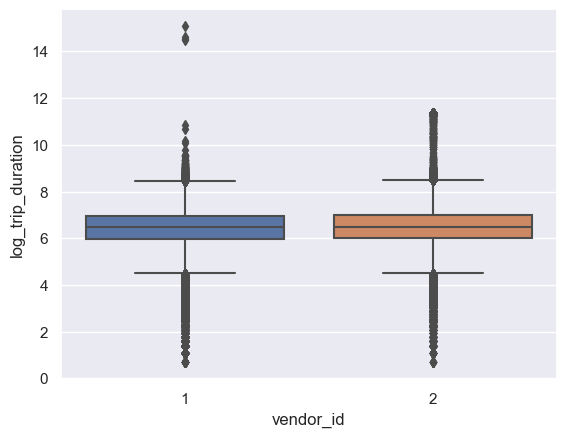

In [80]:
sns.boxplot(data=df, x="vendor_id", y="log_trip_duration")

<AxesSubplot:xlabel='passenger_count', ylabel='log_trip_duration'>

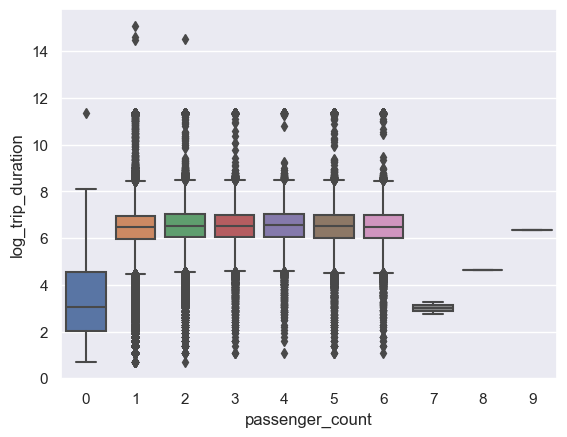

In [81]:
sns.boxplot(data=df, x="passenger_count", y="log_trip_duration")

It would be better if we keep passenger count in [1;6]. 0, 7, 8, 9 looks like errors in data

<AxesSubplot:xlabel='store_and_fwd_flag', ylabel='log_trip_duration'>

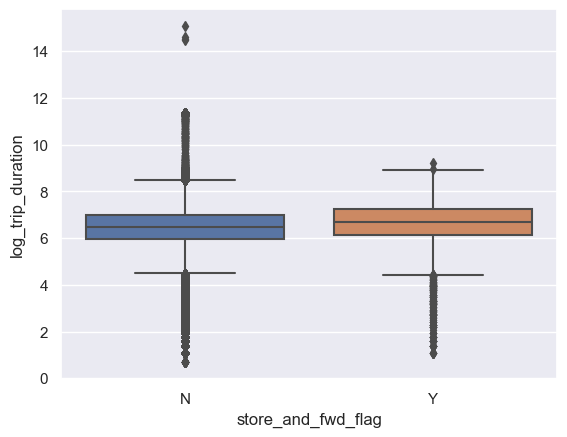

In [82]:
sns.boxplot(data=df, x="store_and_fwd_flag", y="log_trip_duration")

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [83]:
df[['vendor_id', 'log_trip_duration']].corr()['vendor_id']['log_trip_duration']

0.019719502912177528

In [84]:
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].replace({'N':0,'Y':1})

In [85]:
df[['store_and_fwd_flag', 'log_trip_duration']].corr()

,store_and_fwd_flag,log_trip_duration
store_and_fwd_flag,1.000000,0.015326
log_trip_duration,0.015326,1.000000


This feautures has almost no effect on target.

In [86]:
df.drop(columns='vendor_id', inplace=True)
df_test.drop(columns='vendor_id', inplace=True)

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [87]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

+ Удалим из выборки поездки, которые длились ~ менее минуты, предполагая, что это выбросы
+ Удалим поездки с очень большим пройденным расстоянием (маловероятно, что расстояние поездки по городу превышает ~ 100 км)
+ Удалим поездки с большими остатками регрессии

<AxesSubplot:ylabel='Frequency'>

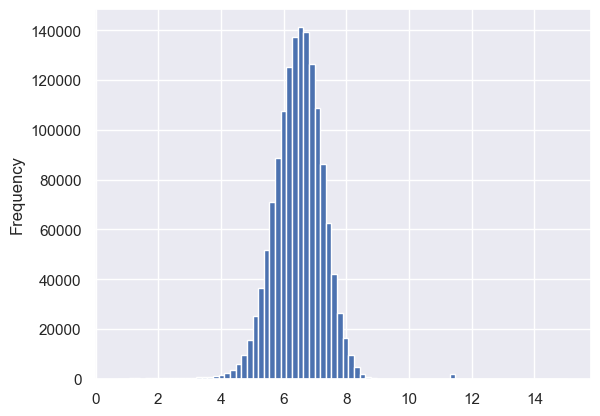

In [88]:
df['log_trip_duration'].plot.hist(bins=80)

<AxesSubplot:ylabel='Frequency'>

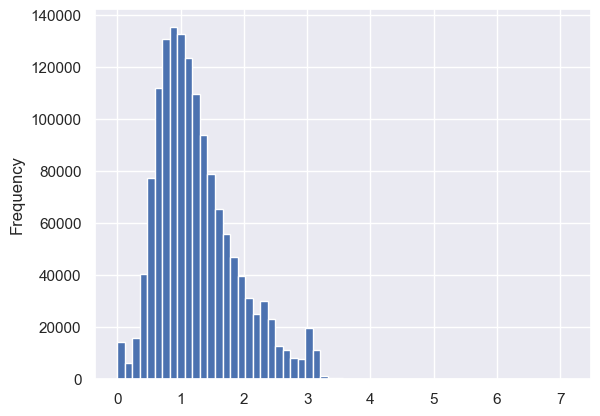

In [89]:
df['log_dist_haversine'].plot.hist(bins=60)

In [90]:
df = df[df['log_trip_duration'] > 4]

In [91]:
df = df[df['log_dist_haversine'] < 4.6]

Check LG residue:

In [92]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(df.drop(columns=['id','pickup_datetime','log_trip_duration']), df['log_trip_duration'])

df['lr_prediction'] = model.predict(df.drop(columns=['id','pickup_datetime','log_trip_duration']))
df['residual'] = df['log_trip_duration'] - df['lr_prediction']

<AxesSubplot:>

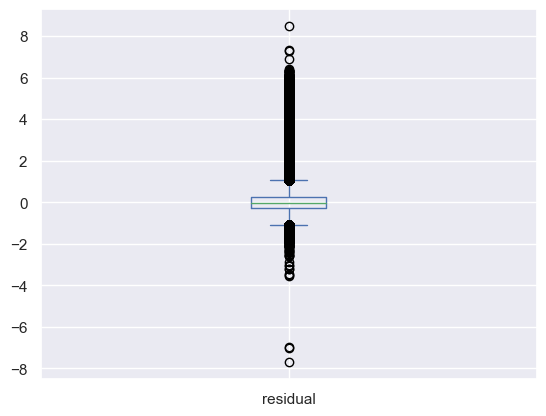

In [93]:
df['residual'].plot.box()

In [94]:
df = df[abs(df['residual']) < 3]

In [95]:
df.drop(columns=['lr_prediction','residual'], inplace=True)

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

Ну я не знаю что тут редкого можно найти, все уже вроде дропнули

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [96]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [97]:
df_r2 = df.copy()

In [98]:
df_r2.drop(columns=['id','pickup_datetime', 'distance_haversine',
                 'pickup_longitude','pickup_latitude',
                 'dropoff_longitude','dropoff_latitude'],
        inplace=True)

In [99]:
X_train = df_r2.drop(columns='log_trip_duration')
y_train = df_r2['log_trip_duration']

In [100]:
ohe_encoder = make_column_transformer(
(OneHotEncoder(), ['store_and_fwd_flag','day_of_week','month',
                   'hour','pickup_square','dropoff_square']),
remainder='passthrough')
#model = Ridge()

In [101]:
model = Pipeline(steps=[('encoder', ohe_encoder),
    ('regression', Ridge())
])

cv_baseline = cross_val_score(
    model,
    X_train,
    y_train,
    cv=5, 
    scoring='neg_root_mean_squared_error').mean()

print(-cv_baseline)

0.4131824139247523


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [103]:
print("Before:", len(df.columns))
print("After:", len(df_r2.columns))

Before: 21
After: 14


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [104]:
model = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('regression', Lasso())
])

cv_baseline = cross_val_score(
    model,
    X_train,
    y_train,
    cv=5, 
    scoring='neg_root_mean_squared_error').mean()

print(-cv_baseline)

0.7308392239949024


Ridge значительно лучше

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [105]:
from sklearn.model_selection import GridSearchCV

In [106]:
X = df_r2.drop(columns='log_trip_duration')
y = df_r2['log_trip_duration']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Best alpha = 10.0000


Text(0, 0.5, 'CV score')

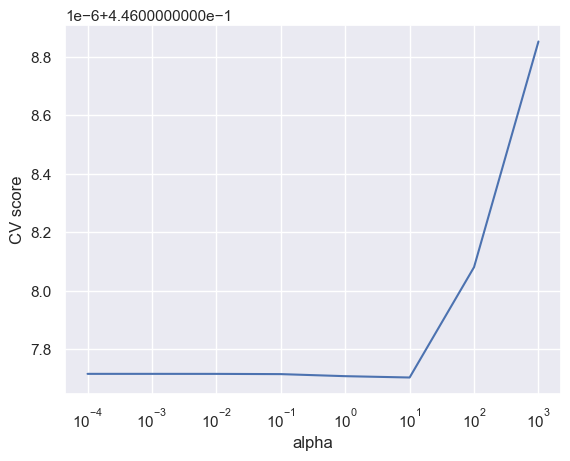

In [108]:
model = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('regression', Ridge())
])

alphas = np.logspace(-4, 3, 8)
searcher = GridSearchCV(model, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=5, n_jobs=3)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [109]:
model = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('regression', Ridge(alpha=10))
])

cv_baseline = cross_val_score(
    model,
    X_test,
    y_test,
    cv=5, 
    scoring='neg_root_mean_squared_error').mean()

print(-cv_baseline)

0.4467634978937959


### Submission

In [117]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  625134 non-null  object        
 1   pickup_datetime     625134 non-null  datetime64[ns]
 2   passenger_count     625134 non-null  int64         
 3   pickup_longitude    625134 non-null  float64       
 4   pickup_latitude     625134 non-null  float64       
 5   dropoff_longitude   625134 non-null  float64       
 6   dropoff_latitude    625134 non-null  float64       
 7   store_and_fwd_flag  625134 non-null  object        
 8   day_of_week         625134 non-null  int64         
 9   month               625134 non-null  int64         
 10  hour                625134 non-null  int64         
 11  is_anomaly_1        625134 non-null  bool          
 12  is_anomaly_2        625134 non-null  bool          
 13  day_of_year         625134 no

In [116]:
mgt = MapGridTransformer(5,5)
df_test = mgt.fit_transform(df_test)

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1448762 entries, 0 to 1458643
Data columns (total 21 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1448762 non-null  object        
 1   pickup_datetime     1448762 non-null  datetime64[ns]
 2   passenger_count     1448762 non-null  int64         
 3   pickup_longitude    1448762 non-null  float64       
 4   pickup_latitude     1448762 non-null  float64       
 5   dropoff_longitude   1448762 non-null  float64       
 6   dropoff_latitude    1448762 non-null  float64       
 7   store_and_fwd_flag  1448762 non-null  int64         
 8   log_trip_duration   1448762 non-null  float64       
 9   day_of_week         1448762 non-null  int64         
 10  month               1448762 non-null  int64         
 11  day                 1448762 non-null  int64         
 12  hour                1448762 non-null  int64         
 13  is_anomaly_1

In [118]:
df_test.drop(columns=['id','pickup_datetime', 'day_of_year',
                 'pickup_longitude','pickup_latitude',
                 'dropoff_longitude','dropoff_latitude'],
        inplace=True)

In [121]:
categorical = [
    'store_and_fwd_flag',
    'day_of_week',
    'month',
    'hour',
    'pickup_square',
    'dropoff_square',]

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [110]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [111]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [112]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [113]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [114]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.